In [ ]:
#connect colab file with drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import modules and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import mean_squared_error

%matplotlib inline

In [ ]:
#load data
folder_path = 'drive/MyDrive/01_SDA_LSTM/data/'
df = pd.read_csv(folder_path + 'df_merged_v2.csv')
df = df.drop(['Unnamed: 0','Fear Classification'], axis=1)

df_future_true = df[df['Date'] > '2021-10-23']
df_future_true = df_future_true[df_future_true['Date'] < '2021-11-23']
df = df[df['Date'] < '2021-10-25']

In [ ]:
#check missing values
print(df.isnull().sum())
print(df_future_true.isnull().sum())

Date                    0
Energy GW               0
BTC Price               0
BTC Volume              0
Fear Index              0
S&P                     0
Electricity Price NY    0
dtype: int64
Date                    0
Energy GW               0
BTC Price               0
BTC Volume              0
Fear Index              0
S&P                     0
Electricity Price NY    0
dtype: int64


In [ ]:
#select features
cols = list(df)[1:7]

#get dates (necessary for visualization)
dataset_train = df
datelist_train = list(df['Date'])
datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]

In [ ]:
#preprocess date format
dataset_train = dataset_train.set_index(['Date'])
dataset_train = dataset_train.set_index(pd.Series(datelist_train))

In [ ]:
#get true values
datelist_future_true = list(df_future_true['Date'])
datelist_future_true = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_future_true]
df_future_true = df_future_true.set_index(['Date'])
df_future_true = df_future_true.set_index(pd.Series(datelist_future_true))
df_future_true.head()

,Energy GW,BTC Price,BTC Volume,Fear Index,S&P,Electricity Price NY
2021-10-24,12.363898,60930.835938,2.731618e+10,73.0,4559.286667,46.12
2021-10-25,12.776117,63039.824219,3.106491e+10,72.0,4566.480000,69.45
2021-10-26,12.717517,60363.792969,3.487897e+10,76.0,4574.790000,62.03
2021-10-27,12.811293,58482.386719,4.365708e+10,73.0,4551.680000,61.37
2021-10-28,12.869905,60622.136719,4.525708e+10,66.0,4596.420000,55.94


In [ ]:
#transform training data
dataset_train = dataset_train[cols]
training_set = dataset_train.to_numpy()
print('Shape of training set == {}.'.format(training_set.shape))
training_set

Shape of training set == (1359, 6).


array([[4.54548750e+00, 9.17054004e+03, 9.95940045e+09, 3.00000000e+01,
        2.82198000e+03, 4.17500000e+01],
       [4.54989356e+00, 8.83075000e+03, 1.27268997e+10, 1.50000000e+01,
        2.76213000e+03, 7.36300000e+01],
       [4.50599090e+00, 9.17491016e+03, 7.26379008e+09, 4.00000000e+01,
        2.72440000e+03, 5.51100000e+01],
       ...,
       [1.22728923e+01, 6.06922656e+04, 3.84340828e+10, 7.50000000e+01,
        4.54490000e+03, 5.91700000e+01],
       [1.24282509e+01, 6.13936172e+04, 2.68825460e+10, 7.40000000e+01,
        4.55209333e+03, 4.97100000e+01],
       [1.23638978e+01, 6.09308359e+04, 2.73161839e+10, 7.30000000e+01,
        4.55928667e+03, 4.61200000e+01]])

In [ ]:
#scale features
sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1])

array([[-1.01351186],
       [-1.01191913],
       [-1.02778931],
       ...,
       [ 1.77983391],
       [ 1.8359938 ],
       [ 1.81273108]])

In [ ]:
#create data structure with 90 timestamps and 1 output
X_train = []
y_train = []

n_future = 30   #days we want to predict
n_past = 90     #days we use to predict

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (1240, 90, 5).
y_train shape == (1240, 1).


In [ ]:
#initialize LSTM model
model = Sequential()

#add first LSTM layer
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, dataset_train.shape[1]-1)))

#add second LSTM layer
model.add(LSTM(units=10, return_sequences=False))

#add Dropout
model.add(Dropout(0.25))

#output layer
model.add(Dense(units=1, activation='linear'))

#compile Neural Network
model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error')



In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 90, 64)            17920     
                                                                 
 lstm_1 (LSTM)               (None, 10)                3000      
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 20,931
Trainable params: 20,931
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#train the model

%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=30, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)

Epoch 1/30
4/4 [==============================] - ETA: 0s - loss: 0.3830
Epoch 00001: val_loss improved from inf to 0.44628, saving model to weights.h5
4/4 [==============================] - 6s 637ms/step - loss: 0.3830 - val_loss: 0.4463 - lr: 0.0100
Epoch 2/30
4/4 [==============================] - ETA: 0s - loss: 0.1727
Epoch 00002: val_loss improved from 0.44628 to 0.30438, saving model to weights.h5
4/4 [==============================] - 1s 270ms/step - loss: 0.1727 - val_loss: 0.3044 - lr: 0.0100
Epoch 3/30
4/4 [==============================] - ETA: 0s - loss: 0.1278
Epoch 00003: val_loss improved from 0.30438 to 0.29685, saving model to weights.h5
4/4 [==============================] - 1s 262ms/step - loss: 0.1278 - val_loss: 0.2968 - lr: 0.0100
Epoch 4/30
4/4 [==============================] - ETA: 0s - loss: 0.1094
Epoch 00004: val_loss improved from 0.29685 to 0.27315, saving model to weights.h5
4/4 [==============================] - 1s 284ms/step - loss: 0.1094 - val_loss: 

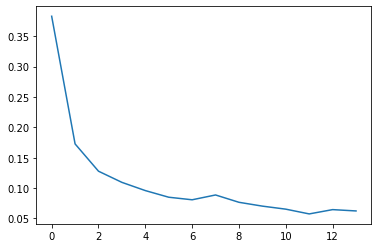

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

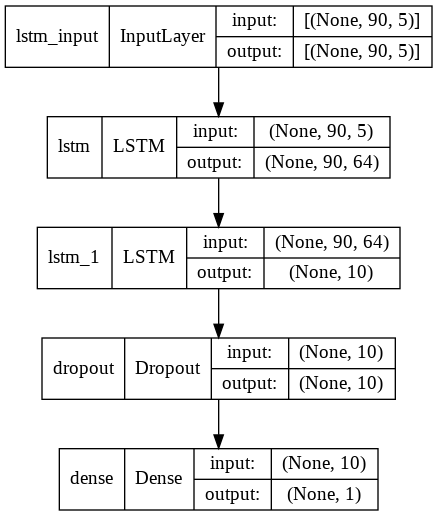

In [ ]:
from keras.utils.vis_utils import plot_model
#to_file='model_plot.png'
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
#generate list for prediction
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()

#convert dates
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

In [ ]:
#perform predictions
predictions_future = model.predict(X_train[-n_future:])
predictions_train = model.predict(X_train[n_past:])

In [ ]:
#adjust data for visualisation
def datetime_to_timestamp(x):
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Energy GW']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['Energy GW']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

dataset_train.index = dataset_train.index.to_series().apply(datetime_to_timestamp)
df_future_true.index = df_future_true.index.to_series().apply(datetime_to_timestamp)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

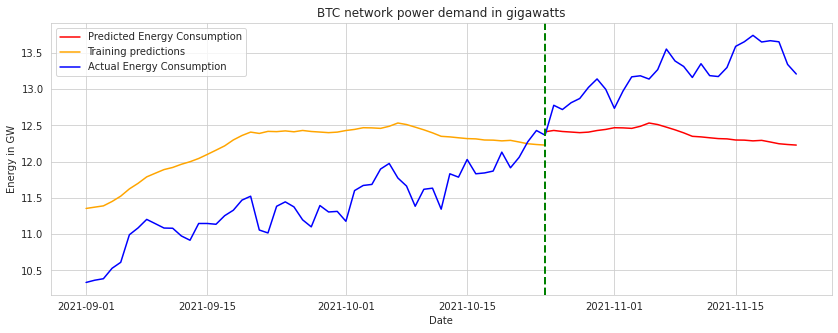

In [ ]:
import seaborn as sns
sns.set_style("whitegrid")

from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

START_DATE_FOR_PLOTTING = '2021-09-01'

ax = sns.lineplot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Energy GW'], color='r', label='Predicted Energy Consumption')
sns.lineplot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Energy GW'], color='orange', label='Training predictions')
sns.lineplot(dataset_train.loc[START_DATE_FOR_PLOTTING:].index, dataset_train.loc[START_DATE_FOR_PLOTTING:]['Energy GW'], color='b', label='Actual Energy Consumption')
sns.lineplot(df_future_true.index, df_future_true['Energy GW'], color='b')
plt.title('BTC network power demand in gigawatts')
ax.set(xlabel='Date', ylabel='Energy in GW')
plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')
plt.savefig(folder_path + 'energy_transparent_lstm.png', dpi=400, transparent=True)
plt.show()
plt.close()


In [ ]:
#rmse
df_val = pd.merge(PREDICTIONS_FUTURE, df_future_true, left_index=True, right_index=True)
df_val = df_val.rename(columns={'Energy GW_y': 'Energy GW', 'Energy GW_x': 'Energy GW Predicted'})
rms = mean_squared_error(df_val['Energy GW'], df_val['Energy GW Predicted'], squared=False)
rms

0.906438935871457